In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import names

In [2]:
df = pd.read_csv("./gradesf2022.csv")

In [3]:
#clean
keep = [hw[0] for hw in pd.Series(df.columns).str.extract("(Assignment \d+ .*)").dropna().values]
keep.insert(0, "Student")
students = df.loc[2:len(df)-2, keep].set_index("Student").astype(float)
final_scores = df.loc[2:len(df)-2, ["Student", "Assignments Final Score"]].set_index("Student").astype(float)

In [4]:
#differences by assignment
diffs=students.diff(periods = 1, axis=1)

#students who grew experience more positive jumps between assignments
def count_positive(x):
    return sum(x>0)
grow_stats = pd.DataFrame(diffs.apply(count_positive, axis=1)).rename(columns={0:"Jump Count"})
#grow_stats

In [5]:
#students who grew experience positive jumps of higher value between assignments
def sum_positive(x):
    return x[x>0].sum()
new_grow_stats = pd.concat([grow_stats, pd.DataFrame(diffs.apply(sum_positive, axis=1))], axis=1).\
            rename(columns={0:"Jump Amount"})

#new_grow_stats

In [6]:
#the top growers were probably a combination of the two
#lets calculate a score that's the mean of the two

scores = pd.DataFrame(new_grow_stats.mean(axis=1).sort_values(ascending=False)).rename(columns={0:"Score"})

#lets get the top 10 scores
growers = scores.nlargest(10, "Score")

#growers

In [7]:
#the score is weighting the jump size and number of jumps equally
#let's see if there's any extraordinary jumpers (by number or size)

highest_jumps = students.loc[diffs.apply(sum_positive, axis=1).nlargest(10).index.values, :]
most_jumps = students.loc[diffs.apply(count_positive, axis=1).nlargest(10).index.values, :]
#display(highest_jumps)
#display(most_jumps)

In [8]:
#add these top performers to the growers list if they don't exist already
outstanding = highest_jumps.merge(most_jumps, how="outer", left_index=True, right_index=True).index.values
#performers

In [9]:
outstander_scores = pd.DataFrame(new_grow_stats.loc[outstanding].mean(axis=1).sort_values(ascending=False)). \
        rename(columns={0:"Score"})

In [10]:
all_growers = scores.loc[pd.concat([growers, outstander_scores]).index.drop_duplicates(), :]
grow_len = len(all_growers)
print(grow_len)
#all_growers

17


In [11]:
#note that the grow_len (in F2022, 17) growers we find are NOT necessarily 
#those with the top grow_len growth scores
#this shows that there are anomalies with high jump frequencies or sizes

top_grow_len = scores.nlargest(grow_len, "Score")

anomalies = scores.loc[all_growers.index.difference(top_grow_len.index), :].sort_values("Score", ascending=False)
#anomalies

In [12]:
#we can now graph the trajectories of the growers, ordered by score

grow_names = all_growers.index.values
traj = (students.loc[grow_names, :]/60)*100
traj.columns = np.arange(1,9) #there are 8 assignments
traj = pd.DataFrame(traj.unstack()).reset_index().rename(columns={"level_0":"Assignment", 0:"Grade"})
#traj

In [13]:
traj_df = traj.pivot(index="Assignment", columns="Student", values="Grade")

#before plotting, for academic privacy reasons, we'll change the names of the students

#generate names
name_list = [names.get_full_name(gender='male') if i%2==0 \
                               else names.get_full_name(gender='female')
                               for i in range(0,grow_len)]
np.random.shuffle(name_list)
##COMMENT THE FOLLOWING LINE TO GET TRUE STUDENT NAMES##
traj_df.columns=name_list

#traj_df

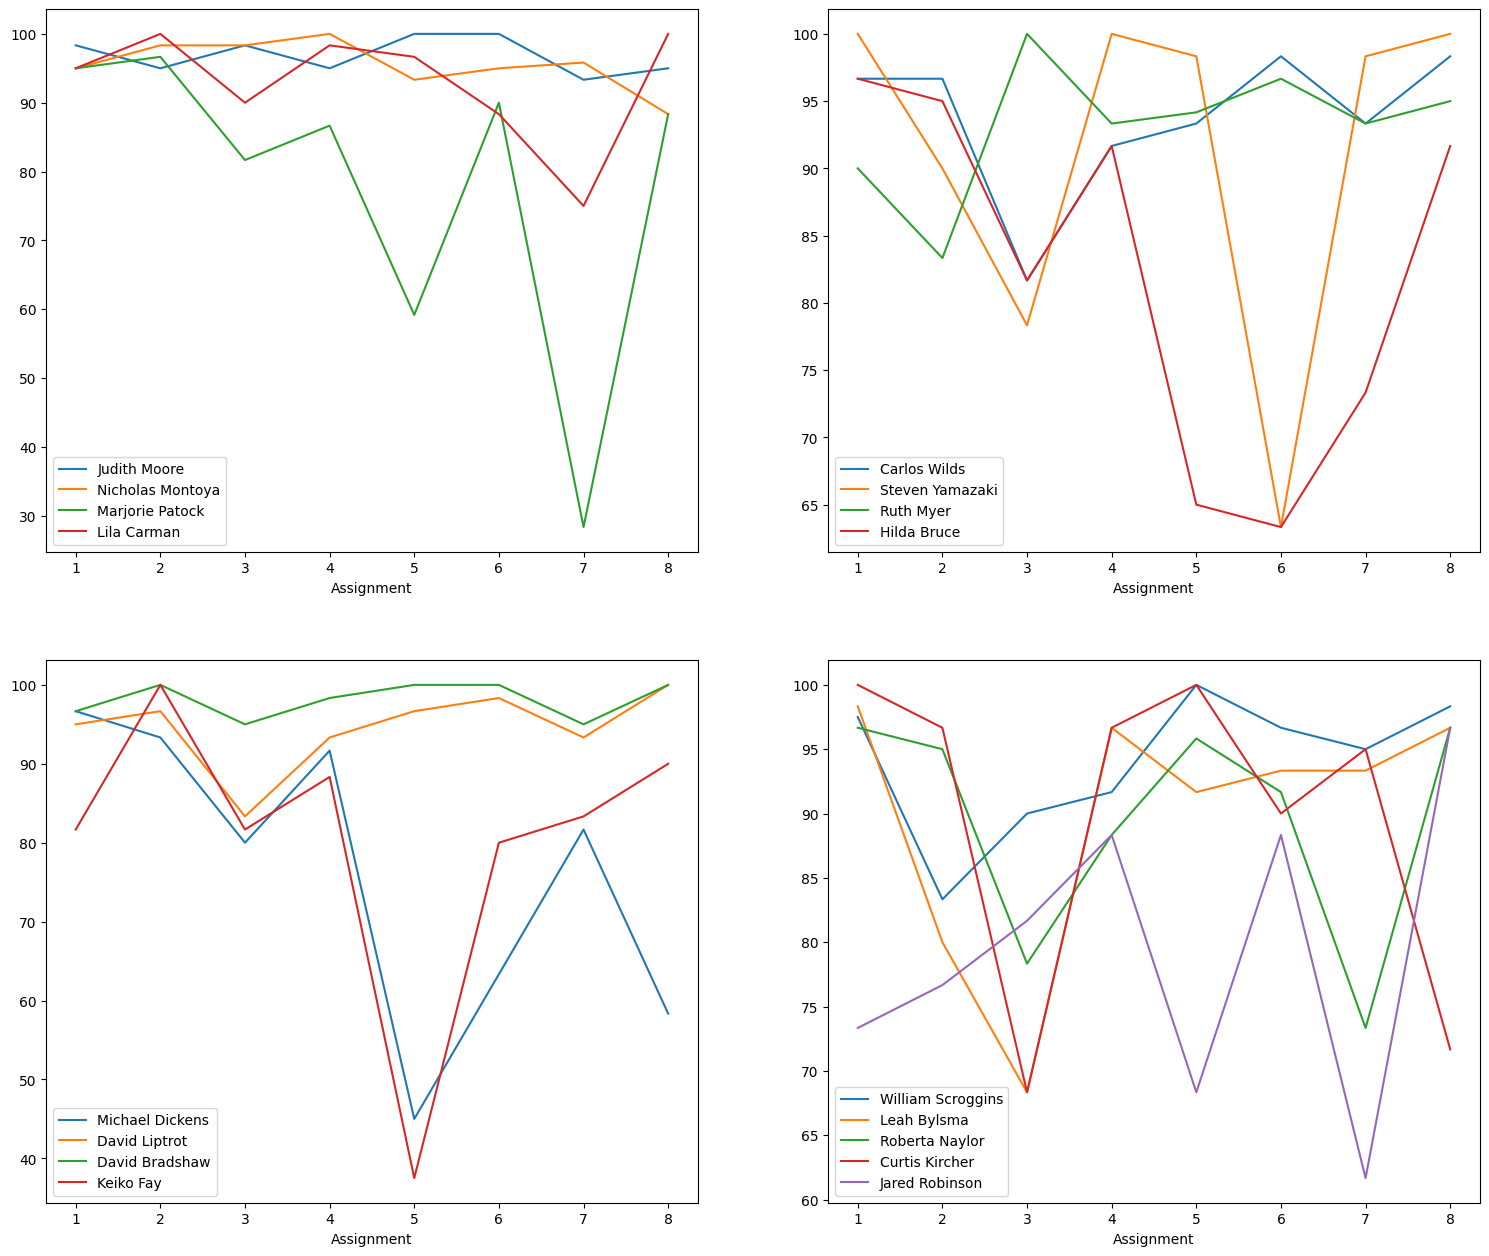

In [14]:
#split grow_len growers into 4 graphs, throw all remainders into the last graph
fig,ax = plt.subplots(2,2)

counter = 0
increment = grow_len//4
remaining = grow_len % 4
for i in range(0,2):
    for j in range(0,2):
        if i==1 and j==1:
            traj_df.iloc[:, counter:counter+increment+remaining].plot(ax=ax[i,j])
        else:
            traj_df.iloc[:, counter:counter+increment].plot(ax=ax[i,j])
            counter += 4


fig.set_size_inches(18.5, 15.5)

pass

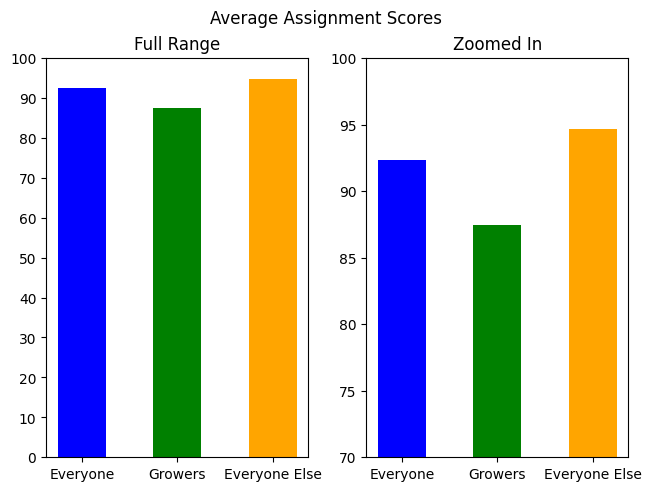

In [15]:
#find overall average and compare to growers' average

overall_avg = np.mean(final_scores.values.flatten())
growers_avg = np.mean(final_scores.loc[grow_names, :].values.flatten())
else_avg = np.mean(final_scores.loc[final_scores.index.difference(all_growers.index), :].values.flatten())

labels = ["Everyone", "Growers", "Everyone Else"]
colors = ["blue", "green", "orange"]
x = np.arange(2,8,2)

fig, ax = plt.subplots(1,2, constrained_layout=True)
#fig.tight_layout(pad=1.0)
fig.suptitle("Average Assignment Scores")
ax[0].bar(x, width = 1, height=[overall_avg, growers_avg, else_avg], color=colors, tick_label=labels)
ax[0].set_yticks(np.arange(0,110,10))
ax[0].set_ylim((0, 100))

ax[1].bar(x, width = 1, height=[overall_avg, growers_avg, else_avg], color=colors, tick_label=labels)
ax[1].set_ylim((70, 100))
ax[0].set_title("Full Range")
ax[1].set_title("Zoomed In")
pass

In [16]:
#that "everyone else" category can probably be broken down into high and low performers

#let's find scorers above the 90th percentile (90% of scores lie below this)
perc90 = np.percentile(final_scores.values.flatten(), 90)
high_performers = final_scores.loc[final_scores.values.flatten()>perc90, :]
#let's find scorers below the 10th percentile (10% of scores lie below this)
perc10 = np.percentile(final_scores.values.flatten(), 10)
low_performers = final_scores.loc[final_scores.values.flatten()<perc10, :]

#make sure none of our growers are in these categories
high_performers = high_performers.loc[high_performers.index.difference(all_growers.index), :]
low_performers = low_performers.loc[low_performers.index.difference(all_growers.index), :]

In [17]:
high_avg = high_performers.values.flatten().mean()
low_avg = low_performers.values.flatten().mean()

all_else = final_scores.index.difference(all_growers.index).difference(high_performers.index). \
    difference(low_performers.index)
allelse_avg = np.mean(final_scores.loc[all_else, :].values.flatten())

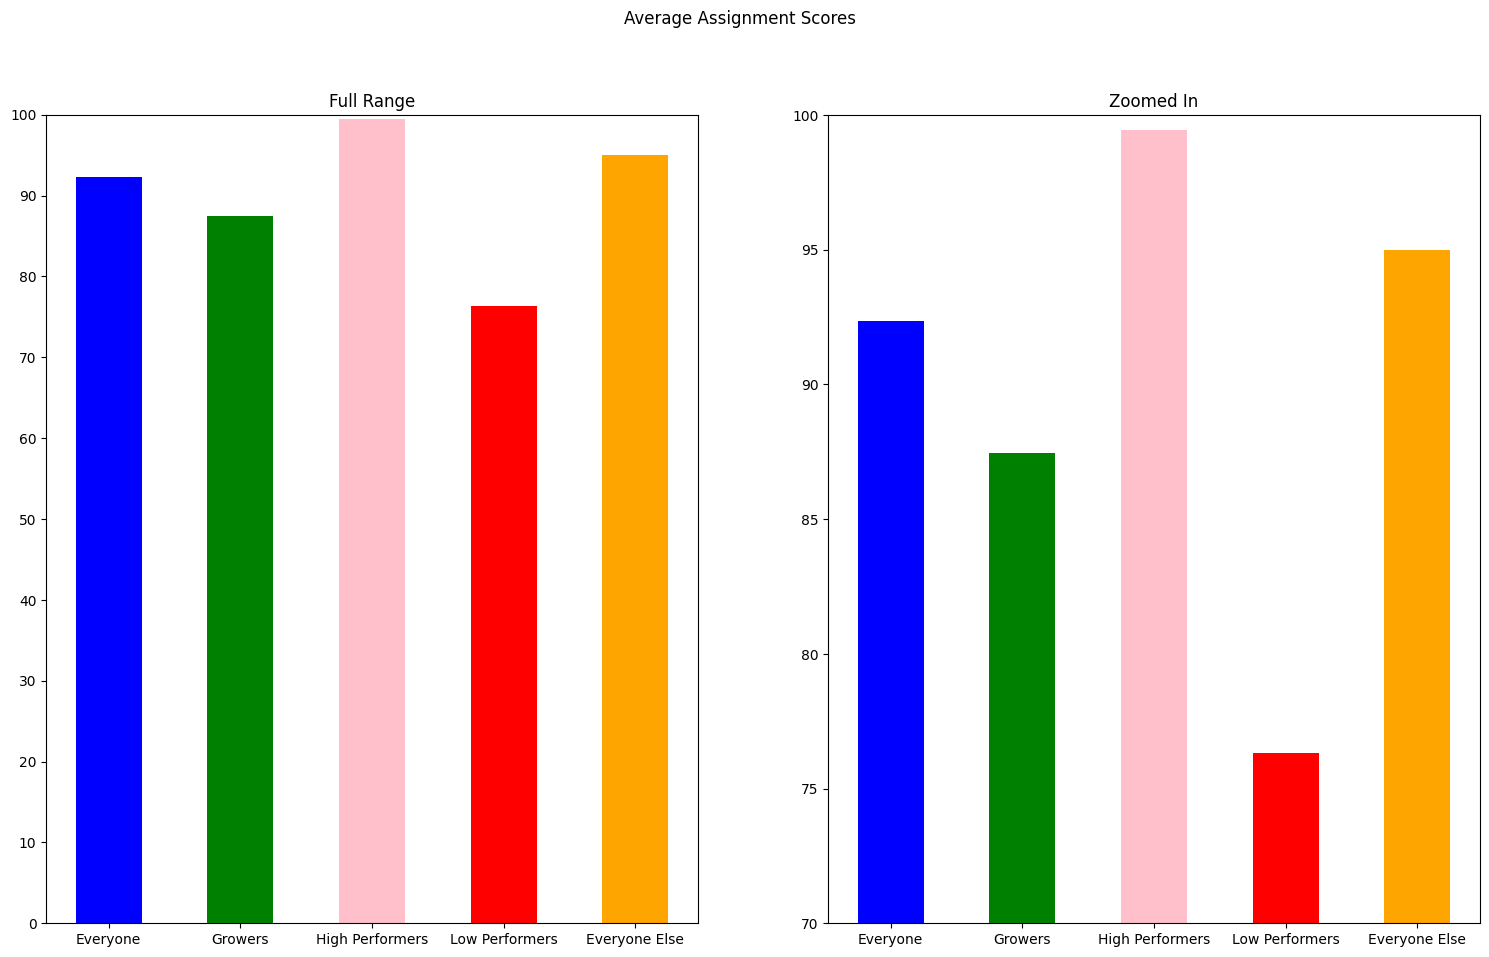

In [18]:
labels = ["Everyone", "Growers", "High Performers", "Low Performers", "Everyone Else"]
colors = ["blue", "green", "pink", "red", "orange"]
x = np.arange(10,60,10)

fig, ax = plt.subplots(1,2)

#fig.tight_layout(pad=5.0)
fig.suptitle("Average Assignment Scores")
ax[0].bar(x, width = 5, height=[overall_avg, growers_avg, high_avg, low_avg, allelse_avg], \
          color=colors, tick_label=labels)
ax[0].set_ylim((0, 100))
ax[0].set_yticks(np.arange(0,110,10))
ax[1].bar(x, width = 5, height=[overall_avg, growers_avg, high_avg, low_avg, allelse_avg], color=colors, tick_label=labels)
ax[1].set_ylim((70, 100))
ax[0].set_title("Full Range")
ax[1].set_title("Zoomed In")

fig.set_size_inches(18.5, 10.5)
pass
